## Galaxy vs quasars

#### Tasks

The dataset is at `solutions/galaxyquasar.csv` (I extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
from astroML.classification import GMMBayes
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
                    
from itertools import combinations

import optuna
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

plt.rcParams['figure.figsize']=(10,7) 
plt.rcParams['font.size']=18 
plt.rcParams['font.family']='Liberation Serif' 
plt.rcParams['figure.autolayout']=True 
plt.rcParams['mathtext.fontset'] = 'cm'

colors = ['palevioletred', 'mediumvioletred', 'darkmagenta', 'mediumblue', 'deepskyblue', 'forestgreen', 'limegreen', 'gold', 'orange', 'red']

In [2]:
path = 'astrostatistics_bicocca_2022-main/solutions/'
data=np.genfromtxt(path+'galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')

In [3]:
labels = np.genfromtxt(path+'galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)
labels = np.where(labels == 'QSO', 1, 0)

d = {
    'u - g': data['u'] - data['g'],
    'g - r': data['g'] - data['r'],
    'r - i': data['r'] - data['i'],
    'i - z': data['i'] - data['z'],
    'Redshift': data['z1'],
    'Type': labels
}

X = np.array([data['u'] - data['g'], data['g'] - data['r'], data['r'] - data['i'], data['i'] - data['z']]).T

keys = ['u - g', 'g - r', 'r - i', 'i - z', 'Redshift', 'Type']

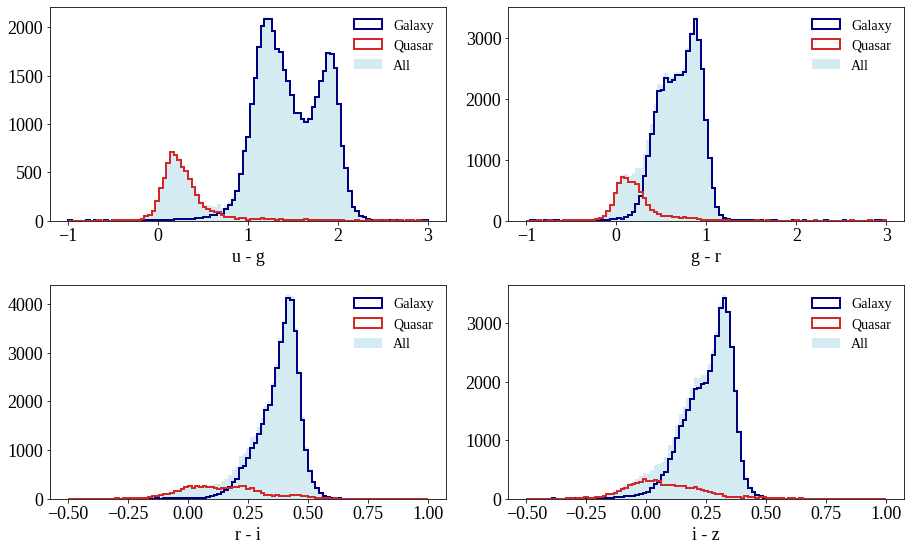

In [4]:
fig, ax = plt.subplots(2, 2, figsize = (13, 8))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
i = 0
for a in axs:
    if i < 2:
        bins = np.linspace(-1, 3, 100)
    else:
        bins = np.linspace(-0.5, 1, 100)
    a.hist(d[keys[i]][labels == 0], bins = bins, histtype = 'step', label = 'Galaxy', color='navy', lw=2);
    a.hist(d[keys[i]][labels == 1], bins = bins, histtype = 'step', label = 'Quasar', color='tab:red', lw=2);
    a.hist(d[keys[i]], bins = bins, color='lightblue', alpha=0.5, label = 'All');
    a.set_xlabel(keys[i])
    a.legend(frameon=False, fontsize=14)
    
    i += 1

Firstly I try to do the classification with QuadraticDiscriminantAnalysis on all possible choices of features (all combinations of 1, 2, 3, 4 features). This method is chosen because it's the one with the weakest assumptions among the classifiers without hyperparameters (which means between GaussianNB, LinearDiscriminantAnalysis and QuadraticDiscriminantAnalysis) and therefore it doesn't need cross-validation. For all features combinations I evaluate accuracy, precision and completeness

In [ ]:
#split data in 60% training points, 20% validation points, 20% test points
X_train, X_temp, Y_train, Y_temp = train_test_split(X, labels, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [5]:
###########   classification with different combinations of features ###############################################

def classification(n_components, classifier, args, Metrics, main_comp=None):
    x, y, z = [], [], []
    features = []
    
    for n in n_components:
        
        comb = list(combinations([0, 1, 2, 3], n))

        for l in comb:
    
            if main_comp is None:
                if n == 1:
                    i = int(l[0])
                    X = d[keys[i]][:, np.newaxis]
                    features.append('(' + keys[i] + ')')

                elif n == 2:
                    i, j = int(l[0]), int(l[1])
                    X = np.array([d[keys[i]], d[keys[j]]]).T
                    features.append('(' + keys[i] + ') + (' + keys[j] + ')')

                elif n == 3:
                    i, j, k = int(l[0]), int(l[1]), int(l[2])
                    X = np.array([d[keys[i]], d[keys[j]], d[keys[k]]]).T
                    features.append('(' + keys[i] + ') + (' + keys[j] + ') + \n (' + keys[k] + ')')

                elif n == 4:
                    X = np.array([d[keys[0]], d[keys[1]], d[keys[2]], d[keys[3]]]).T
                    features.append('(' + keys[0] + ') + (' + keys[1] + ') + \n (' + keys[2] + ') + (' + keys[3] + ')')


                x_train, x_cv, y_train, y_cv = train_test_split(X, d['Type'], test_size=0.3, random_state=42)

                clf = classifier(**args)
                clf.fit(x_train, y_train)

                y_pred = clf.predict(x_cv)

                if 'acc' in Metrics:
                    x.append(metrics.accuracy_score(y_cv, y_pred))
                    y.append(1-metrics.precision_score(y_cv, y_pred))
                    z.append(metrics.recall_score(y_cv, y_pred))
                if 'roc' in Metrics:
                    y_prob = clf.predict_proba(x_cv)[:, 1]
                    fpr, tpr, thresh = roc_curve(y_cv, y_prob)
                    x.append(fpr)
                    y.append(tpr)
                    z.append(thresh)

            elif main_comp is not None and main_comp in l:
                if n == 1:
                    i = int(l[0])
                    X = d[keys[i]][:, np.newaxis]
                    features.append('(' + keys[i] + ')')

                elif n == 2:
                    i, j = int(l[0]), int(l[1])
                    X = np.array([d[keys[i]], d[keys[j]]]).T
                    features.append('(' + keys[i] + ') + (' + keys[j] + ')')

                elif n == 3:
                    i, j, k = int(l[0]), int(l[1]), int(l[2])
                    X = np.array([d[keys[i]], d[keys[j]], d[keys[k]]]).T
                    features.append('(' + keys[i] + ') + (' + keys[j] + ') + \n (' + keys[k] + ')')

                elif n == 4:
                    X = np.array([d[keys[0]], d[keys[1]], d[keys[2]], d[keys[3]]]).T
                    features.append('(' + keys[0] + ') + (' + keys[1] + ') + \n (' + keys[2] + ') + (' + keys[3] + ')')


                x_train, x_cv, y_train, y_cv = train_test_split(X, d['Type'], test_size=0.3, random_state=42)

                clf = classifier(**args)
                clf.fit(x_train, y_train)

                y_pred = clf.predict(x_cv)

                if 'acc' in Metrics:
                    x.append(metrics.accuracy_score(y_cv, y_pred))
                    y.append(1-metrics.precision_score(y_cv, y_pred))
                    z.append(metrics.recall_score(y_cv, y_pred))
                if 'roc' in Metrics:
                    y_prob = clf.predict_proba(x_cv)[:, 1]
                    fpr, tpr, thresh = roc_curve(y_cv, y_prob)
                    x.append(fpr)
                    y.append(tpr)
                    z.append(thresh)
                 
            else:
                continue
                
    return x, y, z, features

####################################################################################################################

## Gaussian Naive Bayes

In [26]:
fpr_GNB, tpr_GNB, thr_GNB, features = classification([1], GaussianNB, dict(priors=None), 'roc')
accuracy_GNB, contamination_GNB, completeness_GNB, features = classification([1, 2, 3, 4], GaussianNB, dict(priors=None), 'acc')

## Linear Discriminant Analysis

In [27]:
fpr_LDA, tpr_LDA, thr_LDA, features = classification([1, 2, 3, 4], LinearDiscriminantAnalysis, dict(solver='svd'), 'roc')
accuracy_LDA, contamination_LDA, completeness_LDA, features = classification([1, 2, 3, 4], LinearDiscriminantAnalysis, dict(solver='svd'), 'acc')

## Quadratic Discriminant Analysis

In [28]:
fpr_QDA, tpr_QDA, thr_QDA, features = classification([1, 2, 3, 4], QuadraticDiscriminantAnalysis, dict(priors=None), 'roc')
accuracy_QDA, contamination_QDA, completeness_QDA, features = classification([1, 2, 3, 4], QuadraticDiscriminantAnalysis, dict(priors=None), 'acc')

## Gaussian Mixture Model

In [29]:
fpr_GMM, tpr_GMM, thr_GMM, features = classification([1, 2, 3, 4], GMMBayes, dict(n_components=5), 'roc')
accuracy_GMM, contamination_GMM, completeness_GMM, features = classification([1, 2, 3, 4], GMMBayes, dict(n_components=5), 'acc')

## K-Nearest Neighbours

In [10]:
fpr_KNN, tpr_KNN, thr_KNN, features = classification([1, 2, 3, 4], KNeighborsClassifier, dict(n_neighbors=5), 'roc')
accuracy_KNN, contamination_KNN, completeness_KNN, features = classification([1, 2, 3, 4], KNeighborsClassifier, dict(n_neighbors=5), 'acc')

## Logistic Regression

In [11]:
fpr_LR, tpr_LR, thr_LR, features = classification([1, 2, 3, 4], LogisticRegression, dict(C=1.0), 'roc')
accuracy_LR, contamination_LR, completeness_LR, features = classification([1, 2, 3, 4], LogisticRegression, dict(C=1.0), 'acc')

Text(0, 0.5, 'Contamination')

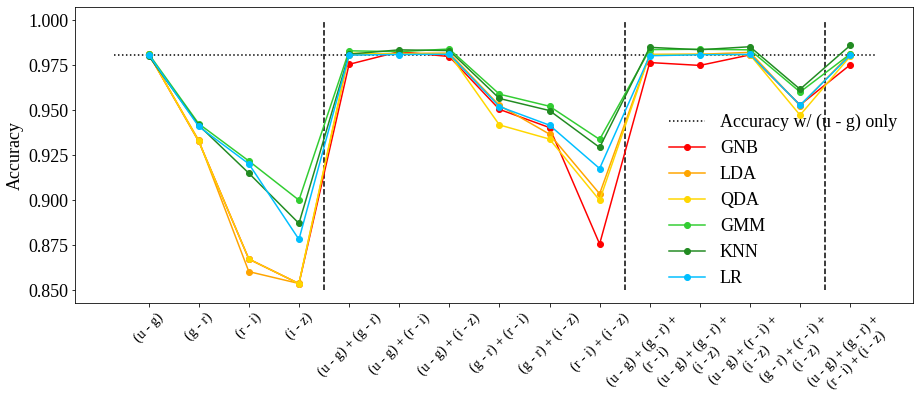

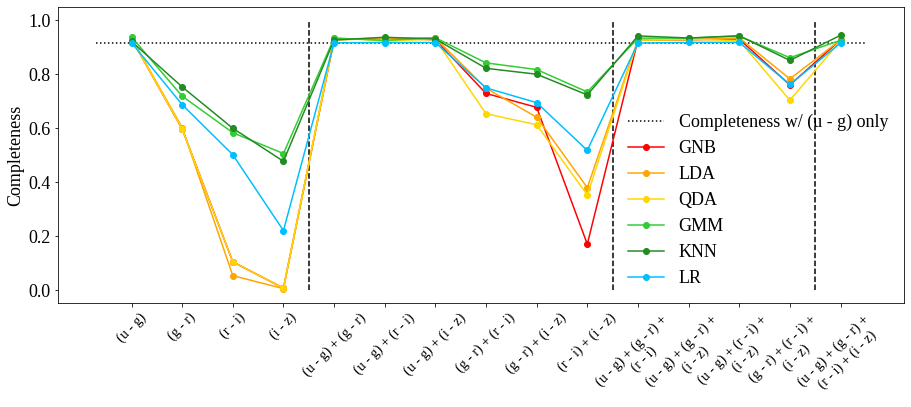

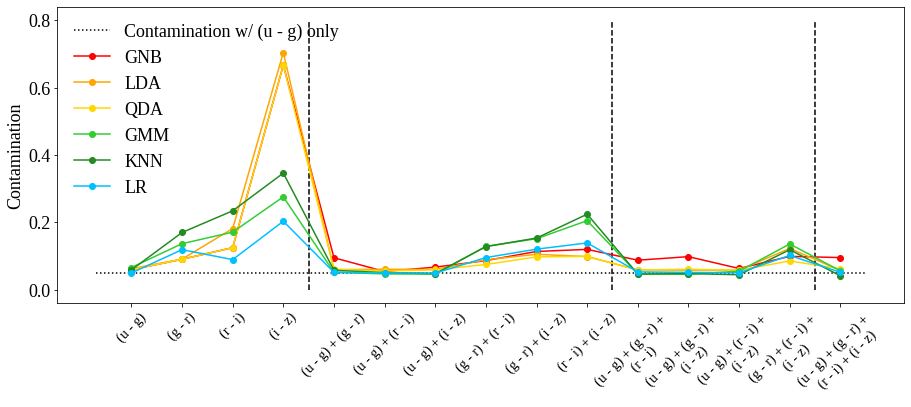

In [12]:
#accuracy
plt.figure(1, figsize=(13, 6))
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_GNB, "Contamination":contamination_GNB, "Completeness":completeness_GNB})
plt.errorbar(x="Features", y = "Accuracy", data=df, color = colors[-1], label = 'GNB', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_LDA, "Contamination":contamination_LDA, "Completeness":completeness_LDA})
plt.errorbar(x="Features", y = "Accuracy", data=df, color = colors[-2], label = 'LDA', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_QDA, "Contamination":contamination_QDA, "Completeness":completeness_QDA})
plt.errorbar(x="Features", y = "Accuracy", data=df, color = colors[-3], label = 'QDA', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_GMM, "Contamination":contamination_GMM, "Completeness":completeness_GMM})
plt.errorbar(x="Features", y = "Accuracy", data=df, color = colors[-4], label = 'GMM', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_KNN, "Contamination":contamination_KNN, "Completeness":completeness_KNN})
plt.errorbar(x="Features", y = "Accuracy", data=df, color = colors[-5], label = 'KNN', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_LR, "Contamination":contamination_LR, "Completeness":completeness_LR})
plt.errorbar(x="Features", y = "Accuracy", data=df, color = colors[-6], label = 'LR', fmt = '-o');

plt.vlines(x = 3.5, ymin = 0.85, ymax = 1, color = 'k', linestyle = '--')
plt.vlines(x = 9.5, ymin = 0.85, ymax = 1, color = 'k', linestyle = '--')
plt.vlines(x = 13.5, ymin = 0.85, ymax = 1, color = 'k', linestyle = '--')
plt.hlines(xmin = -0.7, xmax = 14.5, y = df["Accuracy"][0], color='k', linestyle = ':', label = 'Accuracy w/ (u - g) only')

plt.xticks(rotation=45, fontsize=14);
plt.legend(frameon=False)
plt.ylabel('Accuracy')

#completeness
plt.figure(2, figsize=(13, 6))
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_GNB, "Contamination":contamination_GNB, "Completeness":completeness_GNB})
plt.errorbar(x="Features", y = "Completeness", data=df, color = colors[-1], label = 'GNB', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_LDA, "Contamination":contamination_LDA, "Completeness":completeness_LDA})
plt.errorbar(x="Features", y = "Completeness", data=df, color = colors[-2], label = 'LDA', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_QDA, "Contamination":contamination_QDA, "Completeness":completeness_QDA})
plt.errorbar(x="Features", y = "Completeness", data=df, color = colors[-3], label = 'QDA', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_GMM, "Contamination":contamination_GMM, "Completeness":completeness_GMM})
plt.errorbar(x="Features", y = "Completeness", data=df, color = colors[-4], label = 'GMM', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_KNN, "Contamination":contamination_KNN, "Completeness":completeness_KNN})
plt.errorbar(x="Features", y = "Completeness", data=df, color = colors[-5], label = 'KNN', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_LR, "Contamination":contamination_LR, "Completeness":completeness_LR})
plt.errorbar(x="Features", y = "Completeness", data=df, color = colors[-6], label = 'LR', fmt = '-o');

plt.vlines(x = 3.5, ymin = 0, ymax = 1, color = 'k', linestyle = '--')
plt.vlines(x = 9.5, ymin = 0, ymax = 1, color = 'k', linestyle = '--')
plt.vlines(x = 13.5, ymin = 0, ymax = 1, color = 'k', linestyle = '--')
plt.hlines(xmin = -0.7, xmax = 14.5, y = df["Completeness"][0], color = 'k', linestyle = ':', label = 'Completeness w/ (u - g) only')

plt.xticks(rotation=45, fontsize=14);
plt.legend(frameon=False)
plt.ylabel('Completeness')

#contamination
plt.figure(3, figsize=(13, 6))
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_GNB, "Contamination":contamination_GNB, "Completeness":completeness_GNB})
plt.errorbar(x="Features", y = "Contamination", data=df, color = colors[-1], label = 'GNB', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_LDA, "Contamination":contamination_LDA, "Completeness":completeness_LDA})
plt.errorbar(x="Features", y = "Contamination", data=df, color = colors[-2], label = 'LDA', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_QDA, "Contamination":contamination_QDA, "Completeness":completeness_QDA})
plt.errorbar(x="Features", y = "Contamination", data=df, color = colors[-3], label = 'QDA', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_GMM, "Contamination":contamination_GMM, "Completeness":completeness_GMM})
plt.errorbar(x="Features", y = "Contamination", data=df, color = colors[-4], label = 'GMM', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_KNN, "Contamination":contamination_KNN, "Completeness":completeness_KNN})
plt.errorbar(x="Features", y = "Contamination", data=df, color = colors[-5], label = 'KNN', fmt = '-o');
df = pd.DataFrame({"Features":features, "Accuracy":accuracy_LR, "Contamination":contamination_LR, "Completeness":completeness_LR})
plt.errorbar(x="Features", y = "Contamination", data=df, color = colors[-6], label = 'LR', fmt = '-o');

plt.vlines(x = 3.5, ymin = 0, ymax = 0.8, color = 'k', linestyle = '--')
plt.vlines(x = 9.5, ymin = 0, ymax = 0.8, color = 'k', linestyle = '--')
plt.vlines(x = 13.5, ymin = 0, ymax = 0.8, color = 'k', linestyle = '--')
plt.hlines(xmin = -0.7, xmax = 14.5, y = df["Contamination"][0], color = 'k', linestyle = ':', label = 'Contamination w/ (u - g) only')

plt.xticks(rotation=45, fontsize=14);
plt.legend(frameon=False, loc='upper left')
plt.ylabel('Contamination')

Do the cross-validation on the KNN classifier for the (u-g) case and the all 4 components case

In [32]:
#############   Cross-validation   ################################################

def cross_validation(X, labels, n_split, par_name, par_range, classifier, add_dict):
    #size of each cross-validation set
    cv_size = len(X[:, 0])/n_split
    
    #completeness and contamination are the scoring functions
    completeness_train = []
    contamination_train = []
    completeness_cv = []
    contamination_cv = []
    accuracy_cv = []
    accuracy_train = []
    
    for m in range(n_split):
        print('Number of split:', m)

        indeces = np.arange(int(cv_size*m), int(cv_size*(m+1)), 1)
        x_cv, y_cv = X[int(cv_size*m):int(cv_size*(m+1))], labels[int(cv_size*m):int(cv_size*(m+1))]
        x_train, y_train = np.delete(X, indeces, axis = 0), np.delete(labels, indeces)

        for par in par_range:
            
            par_dict = {par_name: par}
            par_dict.update(add_dict)
            clf = classifier(**par_dict)
            clf.fit(x_train, y_train) 

            y_pred = clf.predict(x_cv)
            CM = sklearn.metrics.confusion_matrix(y_cv, y_pred)
            tn, fp, fn, tp = CM.ravel()
            completeness_cv.append(tp/(tp+fn))
            contamination_cv.append(fp/(tp+fp))
            accuracy_cv.append(sklearn.metrics.accuracy_score(y_cv, y_pred))

            y_pred = clf.predict(x_train)
            CM = sklearn.metrics.confusion_matrix(y_train, y_pred)
            tn, fp, fn, tp = CM.ravel()
            completeness_train.append(tp/(tp+fn))
            contamination_train.append(fp/(tp+fp))
            accuracy_train.append(sklearn.metrics.accuracy_score(y_train, y_pred))

    completeness_cv = np.array(completeness_cv).reshape(n_split, len(par_range))
    contamination_cv = np.array(contamination_cv).reshape(n_split, len(par_range))
    completeness_train = np.array(completeness_train).reshape(n_split, len(par_range))
    contamination_train = np.array(contamination_train).reshape(n_split, len(par_range))
    accuracy_cv = np.array(accuracy_cv).reshape(n_split, len(par_range))
    accuracy_train = np.array(accuracy_train).reshape(n_split, len(par_range))

    return accuracy_cv, accuracy_train, completeness_cv, completeness_train, contamination_cv, contamination_train

###################################################################################

#############   Plot CV results   ################################################

def plot_CV(par_range, n_split, acc_cv, acc_train, comp_cv, comp_train, cont_cv, cont_train):
    #find the best parameter value
    acc_best = np.median(par_range[np.argmax(acc_cv, axis=1)])
    print('Accuracy is maximum for depth = ', acc_best)
    cc_best = np.median(par_range[np.argmax(comp_cv/cont_cv, axis=1)])
    print('Completeness/contamination is maximum for depth = ', cc_best)
    
    #plot the results
    fig, ax = plt.subplots(3, 1, figsize = (8, 8), sharex = True)

    for m in range(n_split):
        if m == 0:
            ax[0].plot(par_range, acc_cv[m], linestyle = '-', c = 'k', label = 'Cross-validation')
            ax[0].plot(par_range, acc_train[m], linestyle = '--', c = 'k', label = 'Training')
            ax[1].plot(par_range, comp_cv[m], linestyle = '-', c = 'k')
            ax[1].plot(par_range, comp_train[m], linestyle = '--', c = 'k')
            ax[2].plot(par_range, cont_cv[m], linestyle = '-', c = 'k')
            ax[2].plot(par_range, cont_train[m], linestyle = '--', c = 'k')
            
        else:
            ax[0].plot(par_range, acc_cv[m], linestyle = '-', c = 'gray', alpha = 0.4)
            ax[0].plot(par_range, acc_train[m], linestyle = '--', c = 'gray', alpha = 0.4)
            ax[1].plot(par_range, comp_cv[m], linestyle = '-', c = 'gray', alpha = 0.4)
            ax[1].plot(par_range, comp_train[m], linestyle = '--', c = 'gray', alpha = 0.4)
            ax[2].plot(par_range, cont_cv[m], linestyle = '-', c = 'gray', alpha = 0.4)
            ax[2].plot(par_range, cont_train[m], linestyle = '--', c = 'gray', alpha = 0.4)

   
    ax[0].vlines(x = acc_best, ymin = np.min(acc_cv), ymax = np.max(acc_train), color = 'tab:red', label = 'Max accuracy')
    ax[1].vlines(x = acc_best, ymin = np.min(comp_cv), ymax = np.max(comp_train), color = 'tab:red')
    ax[2].vlines(x = acc_best, ymin = 0, ymax = np.max(cont_cv), color = 'tab:red')

    ax[0].vlines(x = cc_best, ymin = np.min(acc_cv), ymax = np.max(acc_train), linestyle = '--', color = 'tab:red', label = 'Max comp/cont')
    ax[1].vlines(x = cc_best, ymin = np.min(comp_cv), ymax = np.max(comp_train), linestyle = '--', color = 'tab:red')
    ax[2].vlines(x = cc_best, ymin = 0, ymax = np.max(cont_cv), linestyle = '--', color = 'tab:red')

    ax[0].legend(frameon = False, fontsize=14)
    ax[0].set_ylabel('Accuracy')
    ax[1].set_ylabel('Completness')
    ax[2].set_ylabel('Contamination')
    ax[2].set_xlabel('Tree Depth')

    
    plt.show()

    return acc_best, cc_best

###################################################################################

### Determine K for KNeighborsClassifier

In [33]:
K = np.arange(1, 15, 1)   #k to try
n_split = 5   #number of splits 
cv_size = len(d[keys[0]])/n_split

#1 component
X = d['u - g'][:, np.newaxis]
acc_cv, acc_train, comp_cv, comp_train, cont_cv, cont_train = cross_validation(X, d['Type'], n_split, 'n_neighbors',
                                                                               K, KNeighborsClassifier, 
                                                                               dict(n_jobs=-1))
k_best1 = np.median(K[np.argmax(acc_cv, axis=1)])

#4 components
X = np.array([d[keys[0]], d[keys[1]], d[keys[2]], d[keys[3]]]).T
acc_cv, acc_train, comp_cv, comp_train, cont_cv, cont_train = cross_validation(X, d['Type'], n_split, 'n_neighbors',
                                                                               K, KNeighborsClassifier, 
                                                                               dict(n_jobs=-1))
k_best4 = np.median(K[np.argmax(acc_cv, axis=1)])

Number of split: 0
Number of split: 1
Number of split: 2
Number of split: 3
Number of split: 4
Number of split: 0
Number of split: 1
Number of split: 2
Number of split: 3
Number of split: 4


### Determine the components for GMMBayes

In [34]:
N = np.arange(1, 10, 1)   #k to try

#1 component
X = d['u - g'][:, np.newaxis]
acc_cv, acc_train, comp_cv, comp_train, cont_cv, cont_train = cross_validation(X, d['Type'], n_split, 'n_components',
                                                                               N, GMMBayes, 
                                                                               dict())
n_best1 = np.median(N[np.argmax(acc_cv, axis=1)])

#4 components
X = np.array([d[keys[0]], d[keys[1]], d[keys[2]], d[keys[3]]]).T
acc_cv, acc_train, comp_cv, comp_train, cont_cv, cont_train = cross_validation(X, d['Type'], n_split, 'n_components',
                                                                               N, GMMBayes, 
                                                                               dict())
n_best4 = np.median(N[np.argmax(acc_cv, axis=1)])

Number of split: 0
Number of split: 1
Number of split: 2
Number of split: 3
Number of split: 4
Number of split: 0
Number of split: 1
Number of split: 2
Number of split: 3
Number of split: 4


### Determine the regularization hyperparameter

In [35]:
C = np.linspace(0.1, 5, 10)   #k to try

#1 component
X = d['u - g'][:, np.newaxis]
acc_cv, acc_train, comp_cv, comp_train, cont_cv, cont_train = cross_validation(X, d['Type'], n_split, 'C',
                                                                               C, LogisticRegression, 
                                                                               dict())
C_best1 = np.median(C[np.argmax(acc_cv, axis=1)])

#4 components
X = np.array([d[keys[0]], d[keys[1]], d[keys[2]], d[keys[3]]]).T
acc_cv, acc_train, comp_cv, comp_train, cont_cv, cont_train = cross_validation(X, d['Type'], n_split, 'C',
                                                                               C, LogisticRegression, 
                                                                               dict())

C_best4 = np.median(C[np.argmax(acc_cv, axis=1)])

Number of split: 0
Number of split: 1
Number of split: 2
Number of split: 3
Number of split: 4
Number of split: 0
Number of split: 1
Number of split: 2
Number of split: 3
Number of split: 4


### Evaluate the performance on the test set of all classifiers

In [36]:
###########   Evaluate the classifier performance on the test set   ###############################################

def evaluate_performance(classifier, args, x_train, y_train, x_test, y_test):
    
    clf = classifier(**args)
    clf.fit(x_train, y_train)

    probs = clf.predict_proba(x_test)[:, 1]
    pred = clf.predict(x_test)

    C = sklearn.metrics.confusion_matrix(y_test, pred)
    accuracy = np.sum(C.diagonal()/len(y_test))
    tn, fp, fn, tp = C.ravel()
    completeness = tp/(tp+fn)
    contamination = fp/(tp+fp)
    fpr, tpr, threshold = roc_curve(y_test, probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    return 100*accuracy, 100*completeness, 100*contamination, fpr, tpr

In [37]:
accuracy_GNB, completeness_GNB, contamination_GNB, fpr_GNB, tpr_GNB = evaluate_performance(GaussianNB, 
                                                                    dict(), X_train, Y_train, X_test, Y_test)

accuracy_LDA, completeness_LDA, contamination_LDA, fpr_LDA, tpr_LDA = evaluate_performance(LinearDiscriminantAnalysis, 
                                                                    dict(), X_train, Y_train, X_test, Y_test)

accuracy_QDA, completeness_QDA, contamination_QDA, fpr_QDA, tpr_QDA = evaluate_performance(QuadraticDiscriminantAnalysis, 
                                                                    dict(), X_train, Y_train, X_test, Y_test)

accuracy_KNN, completeness_KNN, contamination_KNN, fpr_KNN, tpr_KNN = evaluate_performance(KNeighborsClassifier, 
                                                                    dict(n_neighbors=int(k_best4)), X_train, Y_train, X_test, Y_test)

accuracy_GMM, completeness_GMM, contamination_GMM, fpr_GMM, tpr_GMM = evaluate_performance(GMMBayes, 
                                                                    dict(n_components=int(n_best4)), X_train, Y_train, X_test, Y_test)

accuracy_LR, completeness_LR, contamination_LR, fpr_LR, tpr_LR = evaluate_performance(LogisticRegression, 
                                                                    dict(C=C_best4), X_train, Y_train, X_test, Y_test)

In [38]:
X_train_1 = X_train[:, 0]
X_test_1 = X_test[:, 0]

accuracy_GNB_1, completeness_GNB_1, contamination_GNB_1, fpr_GNB_1, tpr_GNB_1 = evaluate_performance(GaussianNB, 
                                                                    dict(), X_train_1[:, np.newaxis], Y_train, X_test_1[:, np.newaxis], Y_test)

accuracy_LDA_1, completeness_LDA_1, contamination_LDA_1, fpr_LDA_1, tpr_LDA_1 = evaluate_performance(LinearDiscriminantAnalysis, 
                                                                    dict(), X_train_1[:, np.newaxis], Y_train,X_test_1[:, np.newaxis], Y_test)

accuracy_QDA_1, completeness_QDA_1, contamination_QDA_1, fpr_QDA_1, tpr_QDA_1 = evaluate_performance(QuadraticDiscriminantAnalysis, 
                                                                    dict(), X_train_1[:, np.newaxis], Y_train, X_test_1[:, np.newaxis], Y_test)

accuracy_KNN_1, completeness_KNN_1, contamination_KNN_1, fpr_KNN_1, tpr_KNN_1 = evaluate_performance(KNeighborsClassifier, 
                                                                    dict(n_neighbors=int(k_best1)), X_train_1[:, np.newaxis], Y_train, X_test_1[:, np.newaxis], Y_test)

accuracy_GMM_1, completeness_GMM_1, contamination_GMM_1, fpr_GMM_1, tpr_GMM_1 = evaluate_performance(GMMBayes, 
                                                                    dict(n_components=int(n_best1)), X_train_1[:, np.newaxis], Y_train, X_test_1[:, np.newaxis], Y_test)

accuracy_LR_1, completeness_LR_1, contamination_LR_1, fpr_LR_1, tpr_LR_1 = evaluate_performance(LogisticRegression, 
                                                                    dict(C=C_best1), X_train_1[:, np.newaxis], Y_train, X_test_1[:, np.newaxis], Y_test)

## Neural network

In [19]:
#rescale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
## train data
class TrainData(Dataset):
  
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
val_data = TrainData(torch.FloatTensor(X_val), torch.FloatTensor(Y_val))
test_data = TestData(torch.FloatTensor(X_test))

In [21]:
BATCH_SIZE = 64

#data loader divides data into arrays of size BATCH_SIZE which are then propagated independently through the NN
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [15]:
def compute_accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)  # taking the closest integer means setting the threshold at 0.5

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc * 100
    
    return acc

def train(model, train_loader, optimizer):
    model.train()                              #training mode = update the weights
    loss_train = 0
    acc_train = 0
    for X_batch, y_batch in train_loader:
        
        optimizer.zero_grad()                  #reset the gradient
        
        y_prediction = model(X_batch)
        
        loss = criterion(y_prediction, y_batch.unsqueeze(1))
        acc = compute_accuracy(y_prediction, y_batch.unsqueeze(1))
        
        loss.backward()                        #compute the gradient of the loss function
        optimizer.step()                       #update weights according to the gradient
        
        loss_train += loss.item()
        acc_train += acc.item()
        
    return loss_train/len(train_loader), acc_train/len(train_loader)

def test(model, val_loader):
    model.eval()                               #evaluation mode = don't update the weights 
    loss_val = 0
    acc_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            y_prediction = model(X_batch)

            loss = criterion(y_prediction, y_batch.unsqueeze(1))
            acc = compute_accuracy(y_prediction, y_batch.unsqueeze(1))
        
            loss_val += loss.item()
            acc_val += acc.item()
    
    return loss_val/len(val_loader), acc_val/len(val_loader)

The network following parameters of the neural network are optimized through cross-validation:
  - number of layers
  - number of neurons per layer
  - learning rate
  - dropout probability (dropout is inserted because even with few small layers I noticed the NN tends to overfit  the training dataset
The network has a number of neurons per layer increasing moving towards inner layers (to see an example of the 
structure look at exercise 20)

In [2]:
class Net(nn.Module):
    def __init__(self, hidden_dim, layer_dim, dropout_rate):
        super(Net, self).__init__() 

        #list of layers
        self.layers = nn.ModuleList()
        for hdim in np.arange(1, hidden_dim+1, 1):
            if hdim == 1:
                self.layers.append(nn.Linear(4, layer_dim))
                self.layers.append(nn.Dropout(p=dropout_rate))
                actual_layer = layer_dim

            elif hdim == hidden_dim+1:
                self.layers.append(nn.Linear(actual_layer, layer_dim))
                actual_layer = layer_dim
            else:
                if hdim <= (hidden_dim + 1)/2:
                    self.layers.append(nn.Linear(actual_layer, int(layer_dim*hdim)))
                    self.layers.append(nn.Dropout(p=dropout_rate))
                    actual_layer = int(layer_dim*hdim)
                else:
                    self.layers.append(nn.Linear(actual_layer, int(layer_dim*(hidden_dim+1-hdim))))
                    self.layers.append(nn.Dropout(p=dropout_rate))
                    actual_layer = int(layer_dim*(hidden_dim+1-hdim))

        #output layer
        self.layers.append(nn.Linear(layer_dim, 1))

    def forward(self, inputs):

        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:
                out = torch.relu(layer(inputs))
            else:
                out = torch.relu(layer(out))

        return torch.sigmoid(self.layers[-1](out))
    
def training(model, train_loader, val_loader, optimizer, criterion, epochs):
    
    for epoch in range(1, epochs + 1):        
        model.train()
        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()

            y_prediction = model(X_batch)

            loss = criterion(y_prediction, y_batch.unsqueeze(1))        
            loss.backward()
            optimizer.step()
        
        model.eval() 
        acc_val = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch, y_batch

                y_prediction = model(X_batch)

                acc = compute_accuracy(y_prediction, y_batch.unsqueeze(1))

                acc_val += acc.item()
        
    return acc_val/len(val_loader)

NameError: name 'nn' is not defined

In [10]:
# define our objective function
def validation(trial):

    # configuration
    cfg = {   'n_epochs' : 20,
              'seed' : 42,
              'lr' : trial.suggest_float('lr', 1e-4, 1e-2, log=True), 
              'n_layers': trial.suggest_float('hidden_dim', 1, 10, step=2),
              'n_neurons': trial.suggest_float('layer_dim', 10, 150, step = 10),
              'dropout': trial.suggest_float('dropout', 0.1, 0.5, step=0.1),
              #'optimizer': trial.suggest_categorical('optimizer',[torch.optim.SGD, torch.optim.Adam]),
              }

    # model
    model = Net(hidden_dim = int(cfg['n_layers']), layer_dim = int(cfg['n_neurons']), dropout_rate = cfg['dropout'])
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])

    best_valid_acc = training(model, train_loader, val_loader, optimizer, criterion, 
                      epochs = cfg['n_epochs'])

    return best_valid_acc

In [106]:
# the sampler determines the parameter values to be evaluated in a trial
sampler = optuna.samplers.TPESampler()
    
study = optuna.create_study(sampler=sampler, direction='maximize') #maximize the accuracy of the validation set after
                                                                   #20 epochs
study.optimize(func=validation, n_trials=200)                      #number of trials done

# save into one file.
joblib.dump(study, './optuna_report_qso.pkl')

[I 2022-12-12 19:00:51,454] A new study created in memory with name: no-name-b9cc15ed-2435-42ff-97f5-de94bd0bf7d3
/home/irene/.local/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [1, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 9.0].
  warnings.warn(
[I 2022-12-12 19:02:14,989] Trial 0 finished with value: 98.06666666666666 and parameters: {'lr': 0.0061962652367872776, 'hidden_dim': 7.0, 'layer_dim': 60.0, 'dropout': 0.1}. Best is trial 0 with value: 98.06666666666666.
[I 2022-12-12 19:03:59,119] Trial 1 finished with value: 98.4 and parameters: {'lr': 0.00011448237636830297, 'hidden_dim': 9.0, 'layer_dim': 40.0, 'dropout': 0.2}. Best is trial 1 with value: 98.4.
[I 2022-12-12 19:04:32,356] Trial 2 finished with value: 98.43333333333334 and parameters: {'lr': 0.004689497783989836, 'hidden_dim': 1.0, 'layer_dim': 130.0, 'dropout': 0.5}. Best is trial 2 with value: 98.43333333333334.
[I 2022-

[I 2022-12-12 19:48:44,991] Trial 34 finished with value: 98.38666666666667 and parameters: {'lr': 0.00021609399741752698, 'hidden_dim': 5.0, 'layer_dim': 130.0, 'dropout': 0.2}. Best is trial 23 with value: 98.56666666666666.
[I 2022-12-12 19:50:18,263] Trial 35 finished with value: 98.53333333333333 and parameters: {'lr': 0.000615380552547989, 'hidden_dim': 7.0, 'layer_dim': 70.0, 'dropout': 0.1}. Best is trial 23 with value: 98.56666666666666.
[I 2022-12-12 19:50:51,430] Trial 36 finished with value: 98.22666666666667 and parameters: {'lr': 0.00015066039186595196, 'hidden_dim': 1.0, 'layer_dim': 140.0, 'dropout': 0.2}. Best is trial 23 with value: 98.56666666666666.
[I 2022-12-12 19:52:17,854] Trial 37 finished with value: 98.46 and parameters: {'lr': 0.0013907342404218136, 'hidden_dim': 7.0, 'layer_dim': 50.0, 'dropout': 0.1}. Best is trial 23 with value: 98.56666666666666.
[I 2022-12-12 19:54:50,214] Trial 38 finished with value: 98.44666666666667 and parameters: {'lr': 0.00034995

[I 2022-12-12 20:37:04,784] Trial 69 finished with value: 98.48666666666666 and parameters: {'lr': 0.00013002876091932226, 'hidden_dim': 7.0, 'layer_dim': 100.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 20:38:43,273] Trial 70 finished with value: 98.48 and parameters: {'lr': 0.0004454266552960027, 'hidden_dim': 7.0, 'layer_dim': 110.0, 'dropout': 0.2}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 20:40:17,416] Trial 71 finished with value: 98.55333333333333 and parameters: {'lr': 0.0002278058925522736, 'hidden_dim': 7.0, 'layer_dim': 80.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 20:41:48,396] Trial 72 finished with value: 98.52666666666667 and parameters: {'lr': 0.00021818009431389459, 'hidden_dim': 7.0, 'layer_dim': 80.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 20:43:22,621] Trial 73 finished with value: 98.52 and parameters: {'lr': 0.0001559578367675194

[I 2022-12-12 21:29:53,373] Trial 104 finished with value: 98.44666666666667 and parameters: {'lr': 0.0003649888373007774, 'hidden_dim': 7.0, 'layer_dim': 20.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 21:30:47,037] Trial 105 finished with value: 98.48 and parameters: {'lr': 0.00047274323612204604, 'hidden_dim': 3.0, 'layer_dim': 120.0, 'dropout': 0.4}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 21:32:53,016] Trial 106 finished with value: 98.5 and parameters: {'lr': 0.0003094985520283028, 'hidden_dim': 9.0, 'layer_dim': 90.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 21:34:12,922] Trial 107 finished with value: 98.52 and parameters: {'lr': 0.00013074469417002015, 'hidden_dim': 5.0, 'layer_dim': 150.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 21:35:46,165] Trial 108 finished with value: 98.46 and parameters: {'lr': 0.00195601638471451, 'hidden_dim': 7.0, '

[I 2022-12-12 22:21:58,961] Trial 139 finished with value: 98.57333333333334 and parameters: {'lr': 0.000777197121744847, 'hidden_dim': 5.0, 'layer_dim': 80.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 22:23:09,627] Trial 140 finished with value: 98.56 and parameters: {'lr': 0.000794251063451272, 'hidden_dim': 5.0, 'layer_dim': 80.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 22:24:19,349] Trial 141 finished with value: 98.54 and parameters: {'lr': 0.00073238456402004, 'hidden_dim': 5.0, 'layer_dim': 80.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 22:25:30,307] Trial 142 finished with value: 98.52 and parameters: {'lr': 0.0008658652005377685, 'hidden_dim': 5.0, 'layer_dim': 80.0, 'dropout': 0.1}. Best is trial 64 with value: 98.58666666666667.
[I 2022-12-12 22:26:43,830] Trial 143 finished with value: 98.5 and parameters: {'lr': 0.00014068971611146453, 'hidden_dim': 5.0, 'layer

[I 2022-12-12 23:15:10,178] Trial 174 finished with value: 98.51333333333334 and parameters: {'lr': 0.0007065183444991891, 'hidden_dim': 5.0, 'layer_dim': 40.0, 'dropout': 0.1}. Best is trial 173 with value: 98.60666666666667.
[I 2022-12-12 23:16:50,560] Trial 175 finished with value: 98.50666666666666 and parameters: {'lr': 0.0006026483748583225, 'hidden_dim': 5.0, 'layer_dim': 80.0, 'dropout': 0.1}. Best is trial 173 with value: 98.60666666666667.
[I 2022-12-12 23:18:34,431] Trial 176 finished with value: 98.44666666666667 and parameters: {'lr': 0.0005217157301067194, 'hidden_dim': 5.0, 'layer_dim': 90.0, 'dropout': 0.1}. Best is trial 173 with value: 98.60666666666667.
[I 2022-12-12 23:20:19,780] Trial 177 finished with value: 98.46666666666667 and parameters: {'lr': 0.0015775633383115456, 'hidden_dim': 5.0, 'layer_dim': 90.0, 'dropout': 0.1}. Best is trial 173 with value: 98.60666666666667.
[I 2022-12-12 23:22:03,876] Trial 178 finished with value: 98.49333333333334 and parameters:

['./optuna_report_qso.pkl']

In [11]:
# load the saved study
study = joblib.load('./optuna_report_qso.pkl')
# convert in dataframe
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete'], axis=1)
df

,number,value,duration,params_dropout,params_hidden_dim,params_layer_dim,params_lr
0,0,98.066667,0 days 00:01:23.533170,0.1,7.0,60.0,0.006196
1,1,98.400000,0 days 00:01:44.129546,0.2,9.0,40.0,0.000114
2,2,98.433333,0 days 00:00:33.235741,0.5,1.0,130.0,0.004689
3,3,98.280000,0 days 00:00:32.788659,0.2,1.0,30.0,0.002960
4,4,98.440000,0 days 00:00:32.530365,0.5,1.0,140.0,0.005510
...,...,...,...,...,...,...,...
195,195,98.520000,0 days 00:01:46.471480,0.1,5.0,80.0,0.000188
196,196,98.413333,0 days 00:01:47.370790,0.3,5.0,90.0,0.000690
197,197,98.520000,0 days 00:01:45.686462,0.1,5.0,80.0,0.000215
198,198,98.393333,0 days 00:01:49.819229,0.1,5.0,90.0,0.000796


In [12]:
study.best_trial

FrozenTrial(number=173, values=[98.60666666666667], datetime_start=datetime.datetime(2022, 12, 12, 23, 11, 55, 348376), datetime_complete=datetime.datetime(2022, 12, 12, 23, 13, 38, 565525), params={'lr': 0.0007110783575261641, 'hidden_dim': 5.0, 'layer_dim': 90.0, 'dropout': 0.1}, distributions={'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'hidden_dim': FloatDistribution(high=9.0, log=False, low=1.0, step=2.0), 'layer_dim': FloatDistribution(high=150.0, log=False, low=10.0, step=10.0), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=173, state=TrialState.COMPLETE, value=None)

In [13]:
model = Net(hidden_dim = int(study.best_trial.params['hidden_dim']), 
            layer_dim = int(study.best_trial.params['layer_dim']), dropout_rate = study.best_trial.params['dropout'])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=study.best_trial.params['lr'])

In [22]:
EPOCHS = 20

loss_train = []
acc_train = []
loss_val = []
acc_val = []

for e in range(1, EPOCHS+1):
    loss, acc = train(model, train_loader, optimizer)
    loss_train.append(loss)
    acc_train.append(acc)

    print(f'Epoch {e+0:03}: | Loss: {loss:.5f} | Acc: {acc:.3f}')

    loss, acc = test(model, val_loader)
    loss_val.append(loss)
    acc_val.append(acc)
    
    print(f'Valid set: | Loss: {loss:.5f} | Acc: {acc:.3f}')

Epoch 001: | Loss: 0.12370 | Acc: 96.665
Valid set: | Loss: 0.07530 | Acc: 97.867
Epoch 002: | Loss: 0.06757 | Acc: 98.193
Valid set: | Loss: 0.05894 | Acc: 98.393
Epoch 003: | Loss: 0.06360 | Acc: 98.233
Valid set: | Loss: 0.06122 | Acc: 98.420
Epoch 004: | Loss: 0.06046 | Acc: 98.288
Valid set: | Loss: 0.05771 | Acc: 98.460
Epoch 005: | Loss: 0.05831 | Acc: 98.383
Valid set: | Loss: 0.05650 | Acc: 98.460
Epoch 006: | Loss: 0.05736 | Acc: 98.388
Valid set: | Loss: 0.05394 | Acc: 98.400
Epoch 007: | Loss: 0.05492 | Acc: 98.452
Valid set: | Loss: 0.05963 | Acc: 98.453
Epoch 008: | Loss: 0.05518 | Acc: 98.457
Valid set: | Loss: 0.05665 | Acc: 98.347
Epoch 009: | Loss: 0.05380 | Acc: 98.472
Valid set: | Loss: 0.05932 | Acc: 98.347
Epoch 010: | Loss: 0.05405 | Acc: 98.517
Valid set: | Loss: 0.05449 | Acc: 98.493
Epoch 011: | Loss: 0.05316 | Acc: 98.497
Valid set: | Loss: 0.05171 | Acc: 98.480
Epoch 012: | Loss: 0.05308 | Acc: 98.517
Valid set: | Loss: 0.05047 | Acc: 98.493
Epoch 013: | Los

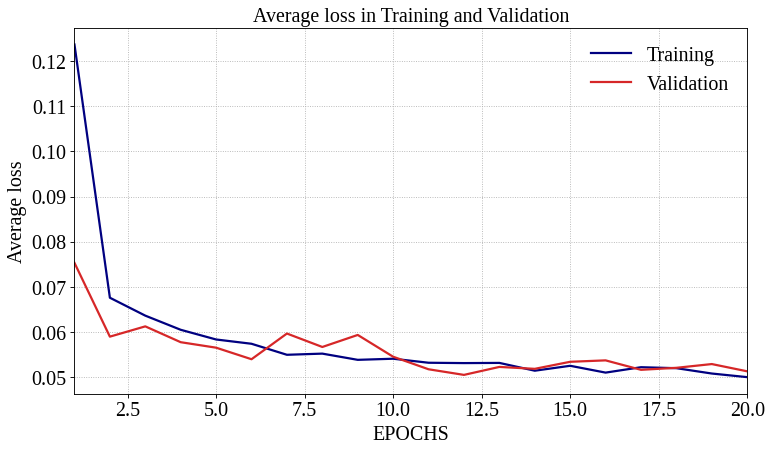

In [23]:
plt.figure(figsize=(10,6), dpi=80) 

plt.plot(np.linspace(1, EPOCHS, EPOCHS), loss_train, label="Training", linewidth = 2, color = 'navy')
plt.plot(np.linspace(1, EPOCHS, EPOCHS), loss_val, label="Validation", linewidth = 2, color = 'tab:red')

plt.xlabel("EPOCHS", fontsize=18)
plt.xlim(1, EPOCHS)
plt.ylabel("Average loss", fontsize=18)
plt.grid(linestyle = ':', which='both')

plt.title("Average loss in Training and Validation", fontsize=18)

plt.legend(loc="upper right", fontsize=18, frameon=False)

plt.show()

### Evaluate the performance of the NN on the test set

In [24]:
probs = model(torch.from_numpy(X_test.astype(np.float32)))
pred = torch.round(probs).detach().numpy().flatten()
probs = probs.detach().numpy().flatten()

C = sklearn.metrics.confusion_matrix(Y_test, pred)
accuracy_NNC = np.sum(C.diagonal()/len(Y_test))*100
tn, fp, fn, tp = C.ravel()
completeness_NNC = tp/(tp+fn)*100
contamination_NNC = fp/(tp+fp)*100
fpr, tpr, threshold = roc_curve(Y_test, probs)
fpr_NNC = np.concatenate([[0], fpr])
tpr_NNC = np.concatenate([[0], tpr])

### Plot all ROC curves and print accuracies to compare the performances of all classifiers tried

GNB
Accuracy: 97.560, completeness: 92.511, contamination:9.535
LDA
Accuracy: 98.287, completeness: 93.311, contamination:5.487
QDA
Accuracy: 98.220, completeness: 92.935, contamination:5.598
KNN
Accuracy: 98.607, completeness: 93.877, contamination:3.813
GMM
Accuracy: 98.073, completeness: 91.757, contamination:5.529
LR
Accuracy: 98.267, completeness: 92.322, contamination:4.716
NNC
Accuracy: 98.640, completeness: 94.960, contamination:4.591


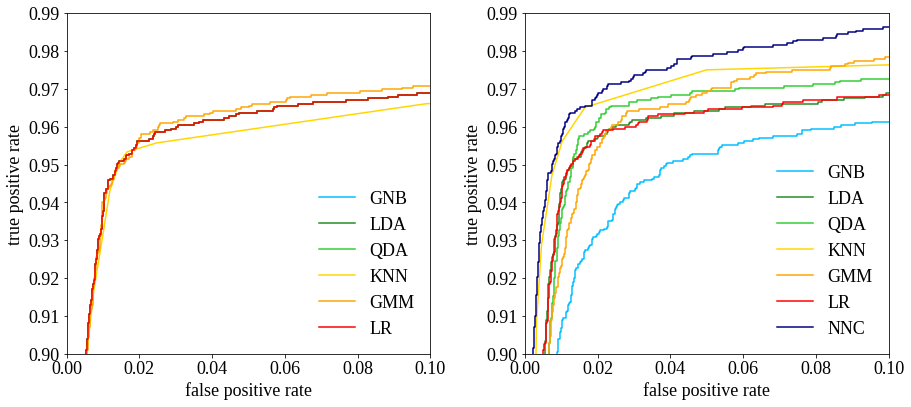

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

ax[0].plot(fpr_GNB_1, tpr_GNB_1, color=colors[4], label='GNB')
ax[0].plot(fpr_LDA_1, tpr_LDA_1, color=colors[5], label='LDA')
ax[0].plot(fpr_QDA_1, tpr_QDA_1, color=colors[6], label='QDA')
ax[0].plot(fpr_KNN_1, tpr_KNN_1, color=colors[7], label='KNN')
ax[0].plot(fpr_GMM_1, tpr_GMM_1, color=colors[8], label='GMM')
ax[0].plot(fpr_LR_1, tpr_LR_1, color=colors[9], label='LR')
ax[0].set_xlim(0, 0.1)
ax[0].set_ylim(0.9, 0.99)
ax[0].set_xlabel('false positive rate')
ax[0].set_ylabel('true positive rate')
ax[0].legend(frameon=False)

ax[1].plot(fpr_GNB, tpr_GNB, color=colors[4], label='GNB')
ax[1].plot(fpr_LDA, tpr_LDA, color=colors[5], label='LDA')
ax[1].plot(fpr_QDA, tpr_QDA, color=colors[6], label='QDA')
ax[1].plot(fpr_KNN, tpr_KNN, color=colors[7], label='KNN')
ax[1].plot(fpr_GMM, tpr_GMM, color=colors[8], label='GMM')
ax[1].plot(fpr_LR, tpr_LR, color=colors[9], label='LR')
ax[1].plot(fpr_NNC, tpr_NNC, color='navy', label='NNC')

ax[1].set_xlim(0, 0.1)
ax[1].set_ylim(0.9, 0.99)
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')
ax[1].legend(frameon=False)

print('GNB')
print(f'Accuracy: {accuracy_GNB:.3f}, completeness: {completeness_GNB:.3f}, contamination:{contamination_GNB:.3f}')
print('LDA')
print(f'Accuracy: {accuracy_LDA:.3f}, completeness: {completeness_LDA:.3f}, contamination:{contamination_LDA:.3f}')
print('QDA')
print(f'Accuracy: {accuracy_QDA:.3f}, completeness: {completeness_QDA:.3f}, contamination:{contamination_QDA:.3f}')
print('KNN')
print(f'Accuracy: {accuracy_KNN:.3f}, completeness: {completeness_KNN:.3f}, contamination:{contamination_KNN:.3f}')
print('GMM')
print(f'Accuracy: {accuracy_GMM:.3f}, completeness: {completeness_GMM:.3f}, contamination:{contamination_GMM:.3f}')
print('LR')
print(f'Accuracy: {accuracy_LR:.3f}, completeness: {completeness_LR:.3f}, contamination:{contamination_LR:.3f}')
print('NNC')
print(f'Accuracy: {accuracy_NNC:.3f}, completeness: {completeness_NNC:.3f}, contamination:{contamination_NNC:.3f}')